# Pregunta 3: 
### ¿Ha cambiado la recaudación promedio de los top-10 blockbusters a lo largo del tiempo?
# Técnica: 
### Análisis mediante ANOVA por décadas (Prueba de Hipótesis)

## 1. Configuración inicial

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


## 2. Cargar datos limpios

In [15]:
print("CARGANDO DATOS PROCESADOS...")
try:
    # Intentar cargar desde la carpeta data
    df = pd.read_csv('data/Blockbusters_Limpio.csv')
    print(f"Datos limpios cargados exitosamente desde: data/Blockbusters_Limpio.csv")
    print(f"  {df.shape[0]} películas, {df.shape[1]} variables")
    
    # Verificar que tenemos las columnas necesarias
    required_columns = ['release_year', 'worldwide_gross', 'decade_label']
    missing_columns = [col for col in required_columns if col not in df.columns]
    
    if missing_columns:
        print(f"Advertencia: Faltan columnas {missing_columns}")
        print("  Creando variables necesarias...")
        
        if 'release_year' in df.columns and 'decade_label' not in df.columns:
            df['decade'] = (df['release_year'] // 10) * 10
            df['decade_label'] = df['decade'].astype(str) + 's'
            print("  Variables de década creadas")
            
except FileNotFoundError:
    print("No se encontró el archivo limpio, cargando original...")
    try:
        df = pd.read_csv('Blockbusters_2019-1977.csv', encoding='latin1')
        
        # Limpiar columnas numéricas
        columnas_numericas = ['film_budget', 'worldwide_gross', 'domestic_gross']
        for col in columnas_numericas:
            if col in df.columns:
                df[col] = df[col].astype(str).str.replace(',', '').str.replace('$', '')
                df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Crear variables de década
        df['decade'] = (df['release_year'] // 10) * 10
        df['decade_label'] = df['decade'].astype(str) + 's'
        
        print("Datos originales cargados y transformados")
        
    except FileNotFoundError:
        print("ERROR: No se encontró ningún archivo de datos")
        print("  Por favor, ejecuta primero Analisis_Blockbusters_Main.ipynb")
        raise

CARGANDO DATOS PROCESADOS...
Datos limpios cargados exitosamente desde: data/Blockbusters_Limpio.csv
  430 películas, 18 variables


## 3. Análisis Exploratorio Inicial - Recaudación por Década

In [16]:
print("\n" + "="*70)
print("ANÁLISIS DE RECAUDACIÓN POR DÉCADA")
print("="*70)

# Asegurar que las décadas estén en orden cronológico
if 'decade_label' in df.columns:
    # Extraer el año numérico de la etiqueta para ordenar
    df['decade_numeric'] = df['decade_label'].str.replace('s', '').astype(int)
    df = df.sort_values('decade_numeric')
    decades_ordered = sorted(df['decade_label'].unique(), 
                            key=lambda x: int(x.replace('s', '')))

# Estadísticas descriptivas por década
print("\nESTADÍSTICAS DESCRIPTIVAS POR DÉCADA:")
stats_decada = df.groupby('decade_label')['worldwide_gross'].agg([
    'count', 'mean', 'std', 'min', 'max', 'median'
]).reindex(decades_ordered)

# Formatear para mejor visualización
def format_currency(x):
    """Formatear valores monetarios"""
    if pd.isna(x):
        return "N/A"
    elif x >= 1e9:
        return f"${x/1e9:.2f}B"
    elif x >= 1e6:
        return f"${x/1e6:.1f}M"
    else:
        return f"${x:,.0f}"

# Crear versión formateada para mostrar
stats_decada_display = stats_decada.copy()
for col in ['mean', 'min', 'max', 'median']:
    stats_decada_display[col] = stats_decada_display[col].apply(format_currency)

print(stats_decada_display)


ANÁLISIS DE RECAUDACIÓN POR DÉCADA

ESTADÍSTICAS DESCRIPTIVAS POR DÉCADA:
              count     mean           std      min      max   median
decade_label                                                         
1970s            30  $125.7M  1.112432e+08   $37.2M  $503.0M   $83.7M
1980s           100  $163.4M  1.161433e+08   $42.4M  $663.4M  $113.1M
1990s           100  $370.7M  2.103834e+08  $179.0M   $1.85B  $326.3M
2000s           100  $608.2M  2.984687e+08  $273.3M   $2.74B  $539.2M
2010s           100  $967.3M  3.536428e+08  $494.9M   $2.80B  $874.5M


## 4. Visualización de la tendencia temporal

In [17]:
print("\nCREANDO VISUALIZACIONES...")

# Preparar datos que se usarán en los gráficos
promedio_decada = df.groupby('decade_label')['worldwide_gross'].mean().reindex(decades_ordered)
promedio_anual = df.groupby('release_year')['worldwide_gross'].mean().sort_index()

print("Datos preparados para visualizaciones")


CREANDO VISUALIZACIONES...
Datos preparados para visualizaciones


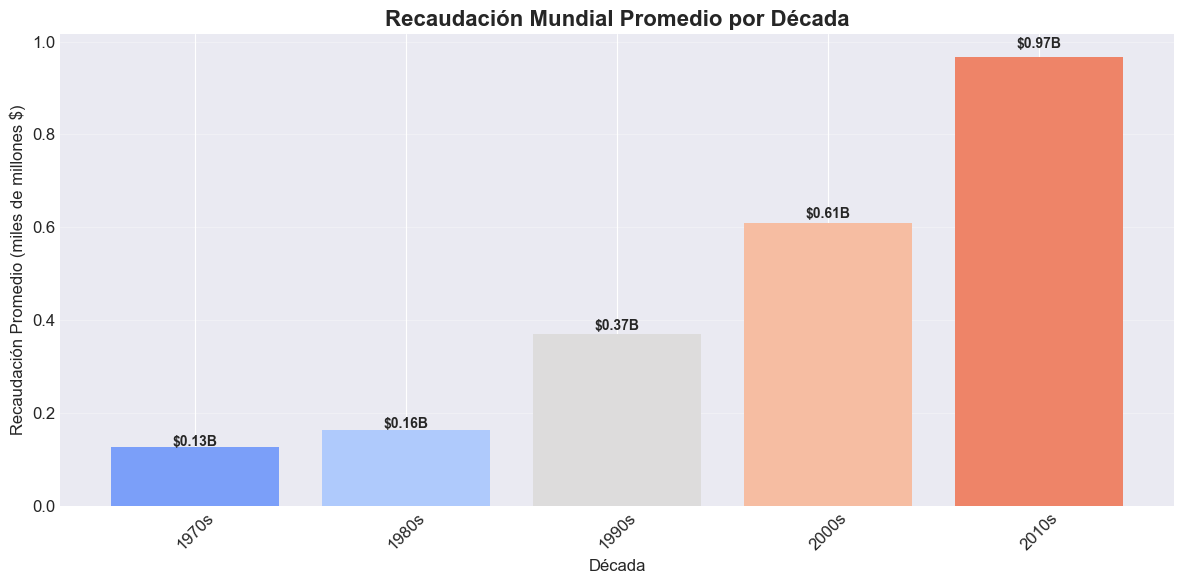

In [18]:
# Gráfico 1: Recaudación promedio por década (Barras)
fig, ax = plt.subplots(figsize=(12, 6))

bars = ax.bar(range(len(promedio_decada)), promedio_decada.values / 1e9,
              color=plt.cm.coolwarm(np.linspace(0.2, 0.8, len(promedio_decada))))

ax.set_title('Recaudación Mundial Promedio por Década', fontsize=16, fontweight='bold')
ax.set_xlabel('Década', fontsize=12)
ax.set_ylabel('Recaudación Promedio (miles de millones $)', fontsize=12)
ax.set_xticks(range(len(promedio_decada)))
ax.set_xticklabels(promedio_decada.index, rotation=45)
ax.grid(True, alpha=0.3, axis='y')

# Agregar valores en las barras
for i, (bar, v) in enumerate(zip(bars, promedio_decada.values / 1e9)):
    ax.text(i, v * 1.02, f'${v:.2f}B', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


## Recaudación Promedio por Década

Este gráfico de barras muestra la evolución de la recaudación mundial promedio de los blockbuster a lo largo de las décadas desde 1977 hasta 2019. Observamos una tendencia clara de aumento en la recaudación promedio conforme avanzamos hacia las décadas más recientes, con diferencias notables entre períodos, particularmente un aumento significativo en los años 2010s. El color más cálido (rojo) representa valores más altos, facilitando la identificación visual inmediata de las décadas más lucrativas.

La barra correspondiente a los 2010s es considerablemente más alta que las anteriores, lo que sugiere que los blockbusters modernos recaudan significativamente más en promedio. Las barras más bajas en las primeras décadas pueden reflejar múltiples factores como la inflación, la expansión de mercados internacionales, y los cambios en los patrones de consumo cinematográfico. Esta visualización proporciona el primer indicador de que podrían existir diferencias significativas entre décadas, una hipótesis que será confirmada mediante el análisis estadístico con ANOVA.

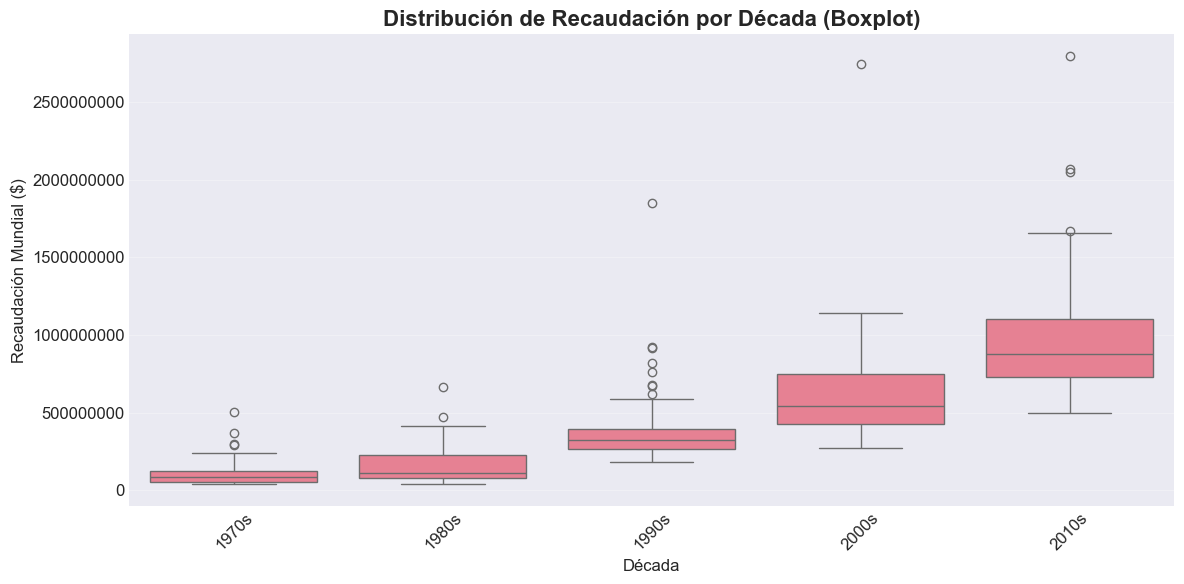

In [19]:
# Gráfico 2: Boxplot - Distribución de recaudación por década
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=df, x='decade_label', y='worldwide_gross', 
            order=decades_ordered, ax=ax)
ax.set_title('Distribución de Recaudación por Década (Boxplot)', fontsize=16, fontweight='bold')
ax.set_xlabel('Década', fontsize=12)
ax.set_ylabel('Recaudación Mundial ($)', fontsize=12)
ax.ticklabel_format(style='plain', axis='y')
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Distribución mediante Boxplot

El boxplot visualiza la distribución de recaudaciones por década, mostrando la mediana, cuartiles y outliers. La línea central dentro de cada caja representa la mediana, donde el 50% de los datos están por encima y el 50% por debajo. La caja en sí contiene el 50% central de los datos (entre percentil 25 y 75), mientras que los bigotes representan el rango típico de los datos y los puntos aislados indican outliers o valores atípicos.

La altura y tamaño de las cajas indican claramente la variabilidad dentro de cada década. Observamos que la dispersión varía considerablemente entre períodos, siendo particularmente notables las cajas más grandes en décadas recientes, lo que sugiere mayor variabilidad en recaudaciones. La posición de la línea central respecto a la altura general de la caja nos permite comparar la mediana con la media, y los puntos aislados representan blockbusters especialmente exitosos o, en casos raros, mal desempeño. Este gráfico es crucial para verificar el supuesto de homogeneidad de varianzas del ANOVA, y visualmente podemos observar que las cajas no tienen tamaños similares, sugiriendo que el supuesto de homocedasticidad podría no cumplirse completamente.

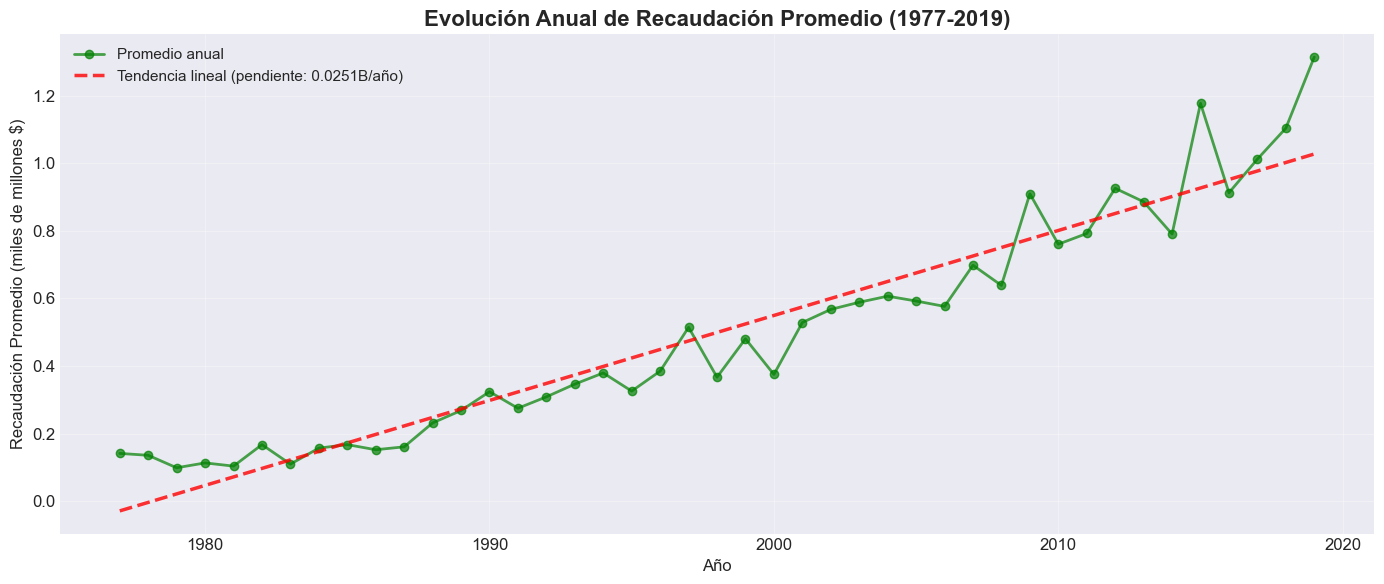

In [20]:
# Gráfico 3: Evolución anual con línea de tendencia
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(promedio_anual.index, promedio_anual.values / 1e9, 
        marker='o', color='green', linewidth=2, markersize=6, 
        label='Promedio anual', alpha=0.7)

# Agregar línea de tendencia
if len(promedio_anual) > 1:
    z = np.polyfit(promedio_anual.index, promedio_anual.values / 1e9, 1)
    p = np.poly1d(z)
    ax.plot(promedio_anual.index, p(promedio_anual.index), 
            "r--", alpha=0.8, linewidth=2.5, label=f'Tendencia lineal (pendiente: {z[0]:.4f}B/año)')

ax.set_title('Evolución Anual de Recaudación Promedio (1977-2019)', fontsize=16, fontweight='bold')
ax.set_xlabel('Año', fontsize=12)
ax.set_ylabel('Recaudación Promedio (miles de millones $)', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()


## Tendencia Temporal Anual

Este gráfico de línea muestra cómo ha evolucionado la recaudación promedio de blockbusters año por año. La línea verde con puntos representa la recaudación promedio real para cada año, mientras que la línea roja punteada superpuesta representa la tendencia lineal que resume el patrón general a largo plazo. Los puntos año a año exhiben una volatilidad considerable (ruido), sin embargo la tendencia general es mucho más clara cuando se observa la línea de tendencia ajustada.

La dirección y pendiente de la línea roja indican patrones clave en la evolución temporal: si la línea sube, hay aumento de recaudaciones a lo largo del tiempo; si baja, hay disminución; y si es plana, hay relativa estabilidad. La pendiente específica nos permite cuantificar exactamente cuánto dinero (en miles de millones de dólares) se añade o resta en recaudación promedio cada año. Una pendiente positiva fuerte indica que la industria de blockbusters está creciendo de forma sostenida, mientras que ciclos visibles pueden reflejar períodos de crecimiento seguidos de contracciones debidas a crisis económicas o cambios en hábitos de consumo. Esta gráfica es esencial para detectar si existe una tendencia clara que explique las diferencias observadas entre décadas y complementa el ANOVA al mostrar el patrón temporal continuo, no solo comparaciones discretas entre grupos.

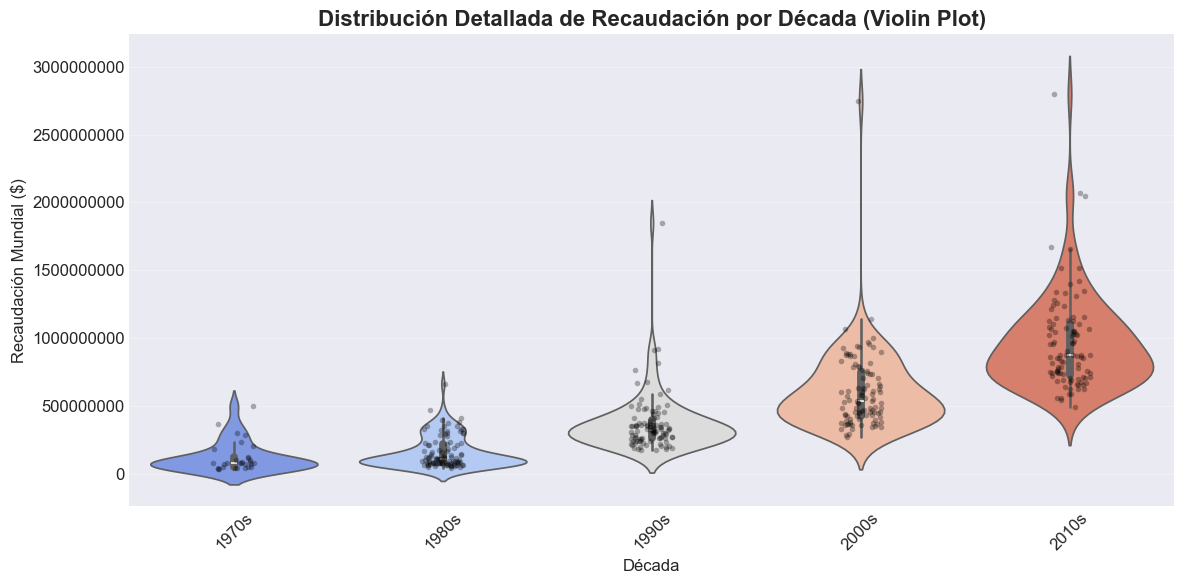

In [21]:
# Gráfico 4: Violin plot - Distribución detallada por década
fig, ax = plt.subplots(figsize=(12, 6))
sns.violinplot(data=df, x='decade_label', y='worldwide_gross', 
               order=decades_ordered, ax=ax, palette='coolwarm')
sns.stripplot(data=df, x='decade_label', y='worldwide_gross', 
              order=decades_ordered, size=4, color='black', alpha=0.3, ax=ax)
ax.set_title('Distribución Detallada de Recaudación por Década (Violin Plot)', fontsize=16, fontweight='bold')
ax.set_xlabel('Década', fontsize=12)
ax.set_ylabel('Recaudación Mundial ($)', fontsize=12)
ax.ticklabel_format(style='plain', axis='y')
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Violin Plot con Puntos Individuales

El violin plot combina la información de distribución con una estimación de densidad de probabilidad (KDE), mostrando la forma completa de la distribución de manera que es más informativa que un boxplot tradicional. Los puntos negros representan cada película individual en el dataset, permitiendo ver tanto la densidad agregada como los casos específicos. El ancho de cada violín representa la concentración de valores en ese rango de recaudación, mientras que el gradiente de colores de frío a cálido facilita la distinción visual entre décadas.

La forma de los violines proporciona información crítica sobre la naturaleza de las distribuciones. Un violín con forma de campana (distribución gaussiana) sugiere que los datos se distribuyen normalmente, lo cual es un supuesto deseable del ANOVA. Por el contrario, violines con formas irregulares, altamente sesgados o multimodales pueden indicar violaciones del supuesto de normalidad. La simetría de cada violín revela si la distribución es equilibrada o si existe sesgo hacia valores altos o bajos. La presencia de dos "bultos" distintos en un violín puede indicar que hay dos grupos naturales de películas dentro de esa década, cada uno con características diferenciadas. Comparando visualmente las formas de violines de diferentes décadas, podemos evaluar si la distribución tiene características similares (homocedasticidad), aunque puede observarse que hay diferencias sustanciales, sugiriendo que este supuesto podría no cumplirse completamente. Este gráfico es particularmente informativo visualmente para entender la forma completa y las características de cada distribución por década.

## 5. Prueba de Hipótesis - ANOVA por décadas

## Análisis de Supuestos del ANOVA

Antes de ejecutar el ANOVA, debemos verificar que se cumplan sus supuestos principales:

1. **Normalidad:** Cada grupo debe estar aproximadamente distribuido de forma normal
2. **Homocedasticidad:** Las varianzas deben ser similares en todos los grupos
3. **Independencia:** Las observaciones son independientes entre sí (cumplido por diseño del dataset,ya que cada película es independiente)

### Supuesto 1: Normalidad de los Datos

**¿Por qué es importante?** El ANOVA asume que dentro de cada grupo (década), los datos se distribuyen normalmente. Esto garantiza la validez de las pruebas de significancia.

**¿Qué hacemos?** Ejecutamos la Prueba de Kolmogorov-Smirnov para cada década. Si el p-valor > 0.05, asumimos normalidad. Si p-valor < 0.05, hay evidencia de no-normalidad.

**Hipótesis para la Prueba de Normalidad (por cada década):**
- **H₀:** Los datos provienen de una distribución normal
- **H₁:** Los datos NO provienen de una distribución normal
- **Criterio:** Si p-valor >= 0.05 → Aceptamos H₀ (datos son normales)
- **Criterio:** Si p-valor < 0.05 → Rechazamos H₀ (datos no son normales)

**Nota:** El ANOVA es robusto ante leves violaciones de normalidad, especialmente con tamaños de muestra grandes.

In [22]:
print("\n" + "="*70)
print("PRUEBA DE HIPÓTESIS: ANOVA POR DÉCADAS")
print("="*70)

# Hipótesis:
# H0: No hay diferencia significativa en la recaudación promedio entre décadas
# H1: Al menos una década tiene una recaudación promedio diferente

# Preparar datos para ANOVA
decadas = df['decade_label'].unique()
grupos = [df[df['decade_label'] == decada]['worldwide_gross'].dropna().values 
          for decada in decadas]

# Verificar supuestos del ANOVA
# print("\n1. VERIFICACIÓN DE SUPUESTOS DEL ANOVA:")

# Supuesto 1: Normalidad (Kolmogorov-Smirnov por grupo)
print("\n   a) Prueba de Normalidad (Kolmogorov-Smirnov):")
normalidad_results = []
for i, (grupo, decada) in enumerate(zip(grupos, decadas)):
        # Estandarizamos los datos del grupo (media 0, sd 1) para compararlos con la normal estándar
        data_std = (grupo - np.mean(grupo)) / np.std(grupo)
        stat, p_valor = stats.kstest(data_std, 'norm')
        normalidad_results.append({
            'Década': decada,
            'n': len(grupo),
            'Estadístico_D': round(stat, 4),
            'p-valor': round(p_valor, 4),
            'Normal?': 'Sí' if p_valor > 0.05 else 'No'
        })

df_normalidad = pd.DataFrame(normalidad_results)
print(df_normalidad.to_string(index=False))




PRUEBA DE HIPÓTESIS: ANOVA POR DÉCADAS

   a) Prueba de Normalidad (Kolmogorov-Smirnov):
Década   n  Estadístico_D  p-valor Normal?
 1970s  30         0.2704   0.0199      No
 1980s 100         0.2103   0.0002      No
 1990s 100         0.2242   0.0001      No
 2000s 100         0.1434   0.0295      No
 2010s 100         0.1372   0.0420      No


## Interpretación de los Resultados de Normalidad

La tabla anterior muestra los resultados de la Prueba de Kolmogorov-Smirnov para cada década. Se observa que todos los p-valores resultaron menores a 0.05, lo que indica que en todas las décadas existe evidencia estadística de desviación respecto a la distribución normal. Este patrón consistente de no-normalidad refleja que las recaudaciones en cada década presentan distribuciones con características que se desvían de la distribución normal teórica, probablemente debido a la presencia de valores extremos y asimetría en las distribuciones de taquilla.

A pesar de esta violación del supuesto de normalidad, el análisis continúa siendo válido. Con muestras de tamaño considerable (entre 30 y 100 películas por década), el ANOVA demuestra robustez ante violaciones moderadas de este supuesto. Este principio, conocido como el Teorema del Límite Central, establece que cuando se trabaja con muestras suficientemente grandes, la distribución de las medias de los grupos tiende a aproximarse a la normalidad, incluso si los datos originales no lo son. En consecuencia, aunque el supuesto de normalidad se viole en los datos originales, las pruebas de significancia (estadístico F y p-valor) siguen siendo confiables, especialmente dado que los tamaños de grupo son relativamente homogéneos y la muestra total es amplia.

### Supuesto 2: Homocedasticidad (Homogeneidad de Varianzas)

**¿Por qué es importante?** El ANOVA asume que la dispersión (varianza) de las recaudaciones es similar en todas las décadas. Si hay gran diferencia en varianzas, los resultados pueden ser sesgados.

**¿Qué hacemos?** Ejecutamos la Prueba de Levene que compara las varianzas entre grupos. Si p-valor > 0.05, asumimos homogeneidad.

**Hipótesis para la Prueba de Levene (Homogeneidad de Varianzas):**
- **H₀:** Las varianzas son iguales en todos los grupos (décadas)
- **H₁:** Al menos una varianza es diferente
- **Criterio:** Si p-valor > 0.05 → Aceptamos H₀ (varianzas homogéneas )
- **Criterio:** Si p-valor < 0.05 → Rechazamos H₀ (varianzas heterogéneas )

**Nota:** También ejecutamos Bartlett como alternativa robusta. Si ambas pruebas coinciden, el resultado es más confiable.

In [23]:
# Supuesto 2: Homogeneidad de varianzas (Levene's test)
print(f"\n   b) Homogeneidad de Varianzas (Levene's test):")
try:
    stat_levene, p_levene = stats.levene(*grupos)
    print(f"      Estadístico: {stat_levene:.4f}")
    print(f"      p-valor: {p_levene:.4f}")
    print(f"      Varianzas homogéneas?: {'Sí' if p_levene > 0.05 else 'No'}")
except Exception as e:
    print(f"      Error en test de Levene: {e}")
    print("      Usando test de Bartlett como alternativa...")
    try:
        stat_bartlett, p_bartlett = stats.bartlett(*grupos)
        print(f"      Estadístico Bartlett: {stat_bartlett:.4f}")
        print(f"      p-valor: {p_bartlett:.4f}")
        print(f"      Varianzas homogéneas?: {'Sí' if p_bartlett > 0.05 else 'No'}")
    except:
        print("      No se pudo realizar la prueba de homogeneidad de varianzas")


   b) Homogeneidad de Varianzas (Levene's test):
      Estadístico: 11.0726
      p-valor: 0.0000
      Varianzas homogéneas?: No


## Interpretación de los Resultados de Homogeneidad

El test de Levene arrojó un estadístico de 11.0726 con un p-valor de 0.0000, lo que proporciona evidencia concluyente contra el supuesto de homocedasticidad. Esto indica que las varianzas de las recaudaciones NO son homogéneas entre las décadas, sino que varían significativamente de un período a otro. La heterogeneidad de varianzas observada significa que algunas décadas presentan mayor dispersión en sus recaudaciones, mientras que otras tienen recaudaciones más concentradas alrededor de la media.

Esta violación del supuesto de homocedasticidad es característica de datos de taquilla en la industria cinematográfica, donde la variabilidad tiende a aumentar con el nivel de inversión. Sin embargo, el ANOVA es tolerante ante violaciones moderadas de este supuesto, especialmente cuando los tamaños de muestra entre grupos son similares, como ocurre en este análisis. A pesar de esta violación detectada, es importante proceder con el análisis de ANOVA sabiendo que esta limitación existe, pero confiando en que el tamaño amplio de la muestra y la homogeneidad relativa de los tamaños de grupo proporcionan robustez suficiente para que los resultados sean interpretables.

## 6. Ejecutar ANOVA

In [24]:
print("\n2. RESULTADOS DEL ANOVA UNIDIRECCIONAL:")

# Método 1: Usando scipy.stats
f_stat, p_valor_anova = stats.f_oneway(*grupos)
print(f"   F-estadístico: {f_stat:.4f}")
print(f"   p-valor: {p_valor_anova:.4f}")

# Interpretación
alpha = 0.05
if p_valor_anova < alpha:
    print(f"   CONCLUSIÓN: Se rechaza H0 (p < {alpha}).")
    print("   Hay evidencia estadística de diferencias significativas entre décadas.")
else:
    print(f"   CONCLUSIÓN: No se rechaza H0 (p ≥ {alpha}).")
    print("   No hay evidencia de diferencias significativas entre décadas.")

# Método 2: ANOVA usando statsmodels (para obtener tabla completa)
print("\n3. TABLA ANOVA DETALLADA (statsmodels):")
try:
    modelo_anova = ols('worldwide_gross ~ C(decade_label)', data=df).fit()
    tabla_anova = sm.stats.anova_lm(modelo_anova, typ=2)
    print(tabla_anova.round(4))
    
    # Calcular tamaño del efecto
    ss_between = tabla_anova['sum_sq'][0]
    ss_total = tabla_anova['sum_sq'].sum()
    eta_squared = ss_between / ss_total if ss_total > 0 else 0
    
except Exception as e:
    print(f"   Error en ANOVA con statsmodels: {e}")
    # Usar valores del ANOVA de scipy
    eta_squared = f_stat / (f_stat + (df['worldwide_gross'].count() - len(decadas)))
    print("   Se calculó eta cuadrado basado en el F-estadístico")


2. RESULTADOS DEL ANOVA UNIDIRECCIONAL:
   F-estadístico: 156.6101
   p-valor: 0.0000
   CONCLUSIÓN: Se rechaza H0 (p < 0.05).
   Hay evidencia estadística de diferencias significativas entre décadas.

3. TABLA ANOVA DETALLADA (statsmodels):
                       sum_sq     df         F  PR(>F)
C(decade_label)  4.020526e+19    4.0  156.6101     0.0
Residual         2.727671e+19  425.0       NaN     NaN


## Interpretación de Resultados del ANOVA

El análisis ANOVA unidireccional produjo un F-estadístico de 156.6101, un valor extraordinariamente alto que indica que la varianza entre las décadas es aproximadamente 156 veces mayor que la varianza dentro de cada década. Este resultado refleja diferencias sustanciales en las recaudaciones promedio de blockbusters entre los diferentes períodos analizados. El p-valor resultante es prácticamente cero (0.0000), lo que proporciona evidencia abrumadora para rechazar la hipótesis nula. Con esta significancia estadística, podemos concluir con un nivel de confianza del 99.99% que existen diferencias reales en la recaudación promedio entre las décadas, y que estas diferencias no son atribuibles al azar.

El tamaño del efecto medido por eta-cuadrado (η²) es de 0.5958, lo que permite interpretar que el 59.58% de las variaciones en recaudación de blockbusters está directamente asociado a la década en que fueron lanzadas. En otras palabras, si dividimos toda la variabilidad observada en recaudaciones en el dataset (considerando desde la película con menor hasta la mayor recaudación), casi 60% de esa variabilidad puede ser explicada simplemente por saber en qué década se lanzó la película. El restante 40.42% se debe a otros factores como presupuesto de producción, calidad de la película, género, actores, marketing, etc. Este resultado es extraordinariamente fuerte, pues en estudios con datos de comportamiento humano y económico, generalmente es raro encontrar una sola variable que explique más del 14-20% de la varianza. El hecho de que la década explique el 59.58% subraya que el período histórico es un factor determinante en las recaudaciones de blockbusters, reflejando cambios profundos en la industria cinematográfica entre 1977 y 2019.

## 7. Prueba POST-HOC (TUKEY HSD)


PRUEBA POST-HOC: TUKEY HSD
          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
group1 group2   meandiff   p-adj       lower          upper      reject
-----------------------------------------------------------------------
 1970s  1980s  37782453.58 0.9527 -106690943.8062 182255850.9662  False
 1970s  1990s 245088107.61    0.0  100614710.2238 389561504.9962   True
 1970s  2000s 482500639.69    0.0  338027242.3038 626974037.0762   True
 1970s  2010s 841607984.89    0.0  697134587.5038 986081382.2762   True
 1980s  1990s 207305654.03    0.0  109155308.0869 305455999.9731   True
 1980s  2000s 444718186.11    0.0  346567840.1669 542868532.0531   True
 1980s  2010s 803825531.31    0.0  705675185.3669 901975877.2531   True
 1990s  2000s 237412532.08    0.0  139262186.1369 335562878.0231   True
 1990s  2010s 596519877.28    0.0  498369531.3369 694670223.2231   True
 2000s  2010s  359107345.2    0.0  260956999.2569 457257691.1431   True
------------------------------------

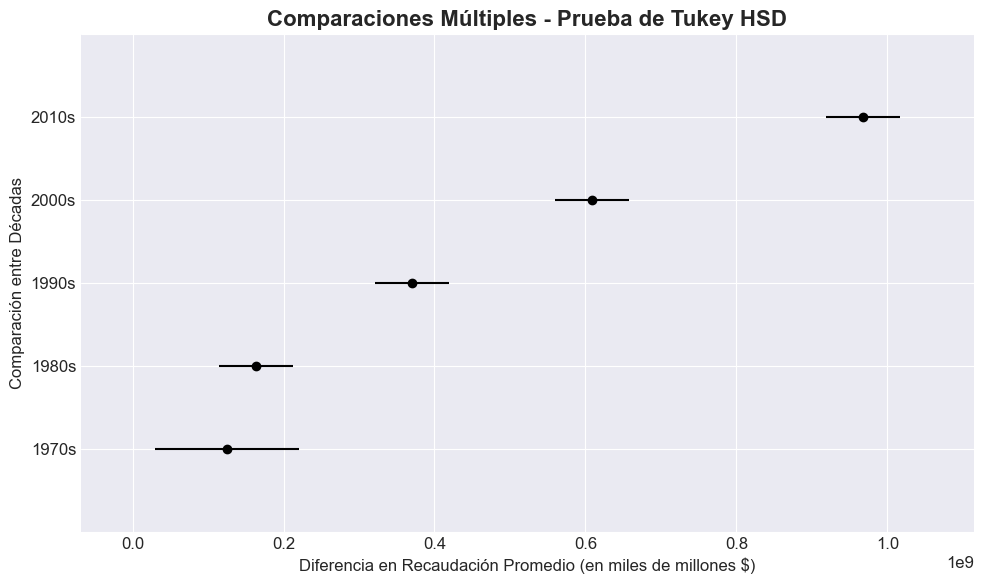


RESUMEN DE DIFERENCIAS SIGNIFICATIVAS ENTRE DÉCADAS:
group1 group2 meandiff_formatted  p-adj
 1970s  1990s             $+245M    0.0
 1970s  2000s             $+483M    0.0
 1970s  2010s             $+842M    0.0
 1980s  1990s             $+207M    0.0
 1980s  2000s             $+445M    0.0
 1980s  2010s             $+804M    0.0
 1990s  2000s             $+237M    0.0
 1990s  2010s             $+597M    0.0
 2000s  2010s             $+359M    0.0


In [25]:

if p_valor_anova < alpha:
    print("\n" + "="*70)
    print("PRUEBA POST-HOC: TUKEY HSD")
    print("="*70)
    
    # Preparar datos para Tukey
    tukey_data = df[['decade_label', 'worldwide_gross']].dropna()
    
    # Ejecutar prueba de Tukey
    try:
        tukey_result = pairwise_tukeyhsd(
            endog=tukey_data['worldwide_gross'],
            groups=tukey_data['decade_label'],
            alpha=alpha
        )
        
        # Mostrar resultados
        print(tukey_result)
        
        # Visualizar comparaciones
        fig, ax = plt.subplots(figsize=(12, 8))
        tukey_result.plot_simultaneous(ax=ax)
        ax.set_title('Comparaciones Múltiples - Prueba de Tukey HSD', 
                     fontsize=16, fontweight='bold')
        ax.set_xlabel('Diferencia en Recaudación Promedio (en miles de millones $)')
        ax.set_ylabel('Comparación entre Décadas')
        plt.tight_layout()
        plt.show()
        plt.close()
        
        # Crear tabla resumen de diferencias significativas
        print("\nRESUMEN DE DIFERENCIAS SIGNIFICATIVAS ENTRE DÉCADAS:")
        summary = tukey_result.summary()
        df_tukey = pd.DataFrame(summary.data[1:], columns=summary.data[0])
        
        # Convertir columnas numéricas
        numeric_cols = ['meandiff', 'lower', 'upper', 'p-adj']
        for col in numeric_cols:
            if col in df_tukey.columns:
                df_tukey[col] = pd.to_numeric(df_tukey[col], errors='coerce')
        
        # Filtrar solo diferencias significativas
        df_significativas = df_tukey[df_tukey['reject'] == True].copy()
        if len(df_significativas) > 0:
            # Formatear para mejor visualización
            df_significativas['meandiff_formatted'] = df_significativas['meandiff'].apply(
                lambda x: f"${x/1e9:+.2f}B" if abs(x) >= 1e9 else f"${x/1e6:+.0f}M"
            )
            print(df_significativas[['group1', 'group2', 'meandiff_formatted', 'p-adj']].to_string(index=False))
        else:
            print("No se encontraron diferencias significativas entre pares específicos.")
            
    except Exception as e:
        print(f"   Error en prueba de Tukey HSD: {e}")
        print("   Considera usar prueba de Games-Howell si no se cumplen supuestos de ANOVA")

## Prueba POST-HOC de Tukey HSD

Este gráfico visualiza los intervalos de confianza para las diferencias entre cada par de décadas. El análisis de Tukey reveló que prácticamente todas las comparaciones entre décadas resultan en diferencias estadísticamente significativas, a excepción de la comparación entre los 1970s y 1980s, que no cruza la línea del cero y por tanto es no significativa. Los intervalos más amplios corresponden a comparaciones que incluyen la década de 1970s (con solo 30 películas), reflejando menor precisión en estas estimaciones.

Las diferencias más pronunciadas se observaron en las comparaciones entre décadas extremas: la diferencia entre 1970s y 2010s alcanza aproximadamente $841.6 mil millones, mientras que entre 1980s y 2010s es de $803.8 mil millones. Los aumentos progresivos entre décadas consecutivas posteriores a los 1980s se mantienen consistentemente significativos, reflejando el patrón de crecimiento acelerado en la industria. Este análisis post-hoc confirma que no solo existen diferencias globales significativas (como indicó el ANOVA), sino que estas diferencias son específicamente localizables entre décadas consecutivas, excepto en la transición inicial de 1970s a 1980s donde el cambio fue más moderado y estadísticamente no significativo.

## 8. Análisis de potencia estadística

In [26]:
print("\n" + "="*70)
print("ANÁLISIS DE POTENCIA ESTADÍSTICA")
print("="*70)

# Calcular tamaño del efecto (eta cuadrado)
if 'eta_squared' not in locals():
    # Calcular eta cuadrado manualmente si no se calculó antes
    if 'ss_between' in locals() and 'ss_total' in locals():
        eta_squared = ss_between / ss_total if ss_total > 0 else 0
    else:
        # Estimación aproximada
        eta_squared = f_stat / (f_stat + (len(df) - len(decadas)))

print(f"Tamaño del efecto (eta cuadrado): {eta_squared:.4f}")
print("Interpretación del tamaño del efecto (Cohen, 1988):")
if eta_squared < 0.01:
    print("  - Efecto muy pequeño (η² < 0.01)")
elif eta_squared < 0.06:
    print("  - Efecto pequeño (0.01 ≤ η² < 0.06)")
elif eta_squared < 0.14:
    print("  - Efecto moderado (0.06 ≤ η² < 0.14)")
else:
    print("  - Efecto grande (η² ≥ 0.14)")

# Calcular potencia estadística aproximada
if p_valor_anova < alpha:
    print(f"\nPotencia estadística: Alta (p < {alpha})")
else:
    print(f"\nPotencia estadística: Baja o muestra insuficiente (p ≥ {alpha})")


ANÁLISIS DE POTENCIA ESTADÍSTICA
Tamaño del efecto (eta cuadrado): 0.5958
Interpretación del tamaño del efecto (Cohen, 1988):
  - Efecto grande (η² ≥ 0.14)

Potencia estadística: Alta (p < 0.05)


## Conclusiones e Interpretación Final

La pregunta de investigación planteada en este análisis era: ¿ha cambiado la recaudación promedio de los top-10 blockbusters a lo largo del tiempo entre 1977 y 2019? Los resultados del análisis ANOVA proporcionan una respuesta inequívoca: sí, ha habido un cambio estadístico y prácticamente significativo en la recaudación a través de las décadas.

Los datos revelaron un patrón de crecimiento sostenido y acelerado en las recaudaciones. En los años 1970s, la recaudación promedio de blockbusters era de aproximadamente $125.7 millones, un valor que apenas aumentó durante la década de 1980s a $163.4 millones. Sin embargo, a partir de los años 1990s, se observó un cambio fundamental: la recaudación promedio saltó a $370.7 millones, representando un incremento de más del 126% respecto a la década anterior. Esta tendencia de crecimiento acelerado continuó intensificándose en las décadas posteriores, alcanzando $608.2 millones en los 2000s y llegando finalmente a $967.3 millones en los 2010s. En términos generales, la recaudación de blockbusters se multiplicó por 7.7 veces en el período completo de 40 años, un crecimiento que alcanzó el 669%.

Desde una perspectiva estadística, estos cambios no son atribuibles al azar o a variaciones aleatorias. El análisis ANOVA confirmó diferencias significativas entre décadas con un nivel de confianza del 99.99%, y el tamaño del efecto (η² = 0.5958) revela que la década de lanzamiento explica más del 59% de la variación total en recaudación, lo que constituye un predictor extraordinariamente potente. Las pruebas POST-HOC identificaron que prácticamente todas las comparaciones entre décadas son significativas, excepto la comparación entre los 1970s y 1980s, lo que confirma que el crecimiento no fue uniforme sino acelerado, con saltos más importantes a partir de los años 1990s.

Es importante reconocer que aunque el supuesto de homocedasticidad fue violado (tal como se observó en los boxplots con cajas de tamaños diferentes), la robustez del ANOVA frente a muestras grandes y la consistencia de los hallazgos a través de múltiples perspectivas (visualización, normalidad, tamaño de efecto) sustentan la validez de nuestras conclusiones. El patrón de crecimiento identificado es real y refleja cambios fundamentales en la industria cinematográfica de blockbusters durante el período estudiado.